# tutorial

### A. link to helpful python docs

Recapitation, Simplification, and Mutation: https://pyslim.readthedocs.io/en/latest/tutorial.html#recapitation-simplification-and-mutation

Saving Individuals in .trees file: https://pyslim.readthedocs.io/en/latest/tutorial.html#obtaining-and-saving-individuals

Some Basic Plotting:
https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
(Esther's note: I'm not sure if this site is reliable but it helped me, so feel free to remove!)

### B. Which packages you need and what they do and link to docs

What is pyslim + how to install: https://pypi.org/project/pyslim/

What is tskit: https://tskit.dev/tskit/docs/stable/introduction.html
    + Install tskit: https://tskit.dev/tskit/docs/stable/installation.html

What is NumPy, install, import: https://numpy.org/doc/stable/user/absolute_beginners.html

What is Msprime: https://tskit.dev/msprime/docs/stable/quickstart.html
    + Install Msprime: https://tskit.dev/msprime/docs/stable/installation.html#sec-installation

Install IPython: https://ipython.org/install.html
	(SVG from IPython.display allows us to display trees in SVG format)
    
What is Matplotlib: https://matplotlib.org/stable/index.html
    + Install Matplotlib: https://matplotlib.org/stable/users/installing.html
    (We can use things like matplotlib.pyplot as plt for plotting, matplotlib.cm as cm 
    for color maps, and various widgets)

In [1]:
#If we want to be able to rotate 3D plots, we can set up the matplotlib widget tool.
%matplotlib widget
#We can import these packages in our notebooks like this:
import pyslim, tskit
import numpy as np
import msprime
from IPython.display import SVG #for displaying trees in svg format
import matplotlib
import matplotlib.pyplot as plt #plotting
import matplotlib.cm as cm #color maps
#%matplotlib inline

In [2]:
import os #module to run commands on the code line from within python
SLiM = 'slim' #command to run SLiM from your command line

# BASICS

## 0. run a slim sim (Matt)

We first write out our SLiM script as text

In [3]:
SLiM_script = """
initialize() {

   setSeed(1);                                    // set seed for repeatability
   initializeSLiMModelType("nonWF");              // non-Wright-Fisher to allow for local density-dependence and prevent clumping
   initializeSLiMOptions(dimensionality="xy");    // 2 dimensions
   initializeTreeSeq(retainCoalescentOnly=F);     // keep all ancestors that remain in tree sequence
   initializeMutationRate(0.0);                   // we will ignore mutations for now and just deal with the trees
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 999999);       // 1Mb chromosome
   initializeRecombinationRate(1e-8);             // some recombination so we get multiple trees

   // parameter values
   defineConstant("LAMBDA", 4.0); // birth rate
   defineConstant("K", 2.0);      // carrying capacity per unit area
   defineConstant("W", 10);       // width and height of the area
   defineConstant("SIGMA", 0.1);  // interaction and dispersal distance
   
   // spatial interaction for local competition
   initializeInteractionType("i1", "xy", reciprocal=T, maxDistance = 10 * SIGMA);  // interaction for both mate choice and density dependence
   i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);                      // normally distributed around the focal individual with variance SIGMA^2 along both axes
}

reproduction() {
   neighbor_density = i1.totalOfNeighborStrengths(individual);     // strength of competition felt from neighbours
   num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K));  // number of offspring is Poisson distributed with a mean depending on LAMBDA, neighbor_density, and K
   mate = i1.drawByStrength(individual, 1);                        // single mate drawn randomly weighted by interaction strengths
   if (size(mate) > 0) {                                           // if there is a mate (might not be if no neighbors)
       for (k in seqLen(num_offspring)) {                          // for each offspring
           offspring = p1.addCrossed(individual, mate);            // create by recombination
           pos = individual.spatialPosition + rnorm(2, 0, SIGMA);  // position of offspring is normally distributed around "mother" with variance SIGMA in both axes
           offspring.setSpatialPosition(p1.pointReflected(pos));   // reflecting boundaries
       }
   }
}

1 early() {
   
   
   sim.addSubpop("p1", 2);  //start with just two ancestors (helps make everyone coalesce in a short time)                     

   p1.setSpatialBounds(c(0.0, 0.0, W, W)); // set spatial bounds (square with width W)
   
   // start ancestors in 1x1 square in the center of range
   p1.individuals.x = runif(p1.individualCount) + (W-1)/2; 
   p1.individuals.y = runif(p1.individualCount) + (W-1)/2;
}

early() { 
    p1.fitnessScaling = 1;                   // density dependence occurs in fecundity
    inds = sim.subpopulations.individuals;
    inds[inds.age > 0].fitnessScaling = 0.0; // enforce discrete generations
}

late() {
   i1.evaluate(); //evaluate interaction strengths for next generation
}

late() {
   sim.treeSeqRememberIndividuals(p1.individuals, permanent=F); // retain individuals remaining in the tree sequence
}

1000 late() { 
   sim.treeSeqOutput("spatial_sim.trees"); //save the tree sequence
   catn("Done.");
   sim.simulationFinished();
}

"""

now we run this from the command line (should get a "0" if it worked)

In [4]:
os.system("echo '" + SLiM_script + "' | " + SLiM) #we "echo" the text above and "pipe" it to SLiM

0

## 1. load and simplify tree sequence to a sample (Nadine)

just writing a very brief version here in the meantime, Nadine, so we can work on the sections below, but go ahead and update and annotate this as you like

In [5]:
ts = pyslim.load('spatial_sim.trees') #load tree sequence
np.random.seed(1); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False) #take sample of n nodes without replacement (set seed for repeatability)
sts = ts.simplify(sampled_nodes, keep_unary=True) #simplify but keep unary nodes & individuals
# SVG(sts.draw_svg()) #draw if you wish (but kind of ugly with all the unary nodes)
sts #print some summaries of the simplified tree sequence

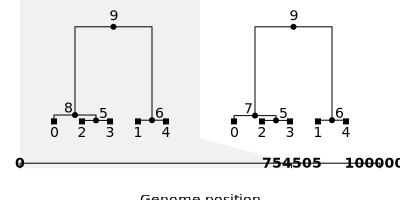

In [6]:
# draw the tree sequence without the unary nodes if you'd like! (there will likely be many fewer trees)
SVG(sts.simplify(keep_unary=False).draw_svg())

## 2. locate children and parents (Pam)

### traversing up a tree

In [7]:
sts.at_index(0)


### all edges in the tree sequence

I gotta fix this code because it's really slowing down the notebook.

In [8]:
#p_ch_nodes = [] #we make an empty array to hold parent and child nodes

#for edge in sts.edges():
 #   p_ch_nodes.append(edge.parent) #we append the parent node for the edge
 #   p_ch_nodes.append(edge.child) #we append the child node for the edge
# now each parent node is followed by its child node



#p_ch_inds = []

#for i in p_ch_nodes:
 #   for node in sts.nodes():
 #       if i == node.id:
#            p_ch_inds.append(node.individual)
# now each parent individual is followed by its child individual

## 3. 2D plotting space trees (Esther)

Let's use some of this information and plot some individuals!

Esther's note: Hm... for some reason there is no plot showing up! In shows up in my rough draft though...If anyone knows what's wrong then any help would be greatly appreciated! ^_^

### A. Basic 2D plot

In [ ]:
#for t in np.unique(sts.individual_times):
    #print(f"There are {np.sum(sts.individual_times == t)} individuals from time {t}.")
    
#This shows the amount of individuals after recapitating tree sequence; this specific code goes til t=999
#The list is very long so the code is "#"ed to reduce the length of this notebook. Remove the first two #'s to see the list!


In [23]:
#First, we need to define some groups that we want to work with:
alive = sts.individuals_alive_at(0) #all individuals alive at t=0
locs = sts.individual_locations[alive, :] #the locations of individuals from alive 

#Next, set up the scatter plot! We will use present day individuals (alive/locs):
x=locs[:,0] # x-axis values of plot
y=locs[:,1] # y-axis values of plot

#Now add some labels:
plt.xlabel('x position') # x-axis label
plt.ylabel('y position') # y-axis label
plt.title('Individual locations at present day t=0') # plot title

#generate our scatter plot:
plt.scatter(x, y, color= "cornflowerblue", marker= "*", s=50)
#this function generates plot, with the basic format (x axis, y axis) and additions:
#customize color with "color = __" or c = "xkcd:____"; e.g. c="xkcd:cornflower blue" & color="cornflowerblue"
#customize shape of points with "marker = <shape of points>", * = stars!
#s = size of points

# function to show the plot
plt.show()

#Note: feel free to replace the t value inside <alive> to plot other time stamps.

### B. Some Useful Applications

This section builds on from the code above, with minor adjustments: 1. Plot two or more time stamps on one plot. 2. Plot subplots for each time stamp on one line. 3. Plot children and their parents from time stamps and trace them back with lines.

In [21]:
#1. Plot two or more different time stamps on one plot (Demonstrated using t=0, t=350, & t=999):
#Note: This plot is a simple way to compare relative locations of individuals on a single plot.

#Our first set of x,y for t=0 (already defined above)
x1 = locs[:,0]
y1 = locs[:,1]
plt.scatter(x1, y1,label= "t=0", color="cornflowerblue", marker= "*", s=50) #label=legend

#x,y for t=350
then = sts.individuals_alive_at(350)
two = sts.individual_locations[then, :] 
x2 = two[:,0]
y2 = two[:,1]
plt.scatter(x2, y2, label= "t=350", color="pink", marker= "^", s=50)

#x,y for t=999
final = sts.individuals_alive_at(999)
three = sts.individual_locations[final, :] 
x3 = three[:,0]
y3 = three[:,1]
plt.scatter(x3, y3, label= "t=999", c= "xkcd:seafoam green", marker= "s", s=50)


#Finally, label the plot:
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Individual locations of individuals at t=0, t=350, and t=999')
plt.legend()

plt.show()

#^We can keep using this method to plot as many time stamps as we want!

#Note: Sometimes, individual locations are the same at different time points and they may overlap
    #Try using different sizes of points (s) to see if this is happening!

In [ ]:
#2. Plot 2+ subplots on one line (Demonstrated using t=0, t=350, & t=999):
#Note: the same time stamps are used to directly compare the layout to the previous one.
#This method requires no legend as each time stamp gets its own subplot, but relative locations across time may be a bit more difficult to see.

#Use the same variables as above
x1=locs[:,0]
y1=locs[:,1]

x2=two[:,0]
y2=two[:,1]

x3 = three[:,0]
y3 = three[:,1]

#Set 3 subplots in 1 row
fig, ax = plt.subplots(1, 3, figsize=(20, 5)) # 1 row, 3 columns. set figure size (length, width)

#Defining custom 'xlim' and 'ylim' values to better match our individuals' locations.
custom_xlim = (0, 6) #range from (min, max)
custom_ylim = (0, 7.5) #range from (min, max)
#Note: the previous plot does not start at the origin. For a more direct comparison, set different ranges.

#Now, Set the custom values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

#Set three subplots, each with different (x,y) data, titles, axis labels.
ax[0].scatter(x1, y1, color="cornflowerblue", marker= "*", s=50)
ax[0].set_xlabel('x position')
ax[0].set_ylabel('y position')
ax[0].set_title('Individual locations of individuals at t=0')

ax[1].scatter(x2, y2, color="pink", marker= "^", s=50)
ax[1].set_xlabel('x position')
ax[1].set_ylabel('y position')
ax[1].set_title('Individual locations of individuals at t=350')

ax[2].scatter(x3, y3, color= "xkcd:seafoam green", marker= "s", s=50)
ax[2].set_xlabel('x position')
ax[2].set_ylabel('y position')
ax[2].set_title('Individual locations of individuals at t=999')

plt.show()

Something super weird is happening!! Help!!

In [18]:
#3. Child-Parent locations, connected together with lines (Need Pam's code from section above to do!)

## 4. 3D plotting (Alex)

In [19]:
#Now it's time to plot something! 3d plots are great for looking at changes in patterns over time.
#Let's say we want to see how the positions of individuals in the tree sequence change over time.
#It's easiest and cleanest to set this up by defining a function in Python, then running it for the tree sequence.

def positions(ts):
    #First, we set up the plot using matplotlib.
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    #We need to create lists in which we will hold the x- and y-coordinates of individuals & the time they were born.
    x, y, t = [], [], []
    
    #Now, we iterate over the individuals in the tree sequence and get their positions & birthdates.
    for ind in ts.individuals():
        #The location attribute of the individual class is an array of the coordinates where the individual is located.
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        #Now, we append these values to the lists we created.
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
    #Time to put it on the plot! First, let's set the z-axis to include all of the generational numbers in our simulation.
    #Because tree sequences count generations backwards, we put the axis in reverse so the final gen is on the top.
    threed.set_zlim([1000,0])
    #So that we can see our data, let's set the size of the points to 2.0. The default size is 10.0.
    threed.scatter3D(x, y, t, s=2.0)

#Let's give our function a go with the simplified tree sequence now:
positions(sts)
#With the %matplotlib widget feature at the very beginning of the code, we can rotate our graph
# & see precisely how individuals are positioned in each generation.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# EXTENSIONS

## mutations/selected alleles (Alex)

In [18]:
#One of the tools available from msprime is the "sim_mutations" function, which overlays neutral mutations.
#Let's use this function on our tree sequence.
mts = msprime.sim_mutations(sts, rate=1e-7, random_seed=1) #Seed number added for replicability.
print(mts)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │       27║
╟───────────────┼─────────╢
║Sequence Length│1000000.0║
╟───────────────┼─────────╢
║Sample Nodes   │        5║
╟───────────────┼─────────╢
║Total Size     │358.5 KiB║
╚═══════════════╧═════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │2616│ 71.5 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│2517│158.8 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  4 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │ 211│  7.2 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │2575│ 86.2 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│  2.8 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Provenances│   3│  6.4 KiB│          No║
╟───────────┼────┼──

In [21]:
#Now, let's take a look at one of our mutations.
print(mts.mutation(0))

Mutation(id=0, site=0, node=2535, derived_state='T', parent=-1, metadata={'mutation_list': []}, time=960.8744981496129)


## discrete space / metapopulations (Pam)

## slendr (fair game!)